In [1]:
# Download data
%run "../dataio/gtsrb_download.py"

2025-11-02 12:54:37,487 - INFO - Downloading GTSRB_Final_Training_Images...
2025-11-02 12:55:37,532 - INFO - Unpacking GTSRB_Final_Training_Images...
2025-11-02 12:55:42,981 - INFO - Downloading GTSRB_Final_Test_Images...
2025-11-02 12:56:05,264 - INFO - Unpacking GTSRB_Final_Test_Images...
2025-11-02 12:56:06,962 - INFO - Downloading GTSRB_Final_Test_GT...
2025-11-02 12:56:07,093 - INFO - Unpacking GTSRB_Final_Test_GT...
2025-11-02 12:56:07,096 - INFO - GTSRB data is ready.
2025-11-02 12:56:08,708 - INFO - GTSRB data cleaned and organized.


In [1]:
%cd ..

/home/marcusp/Documents/traffic-sign-classification


In [2]:
from dataio.transforms import ToCompose, ToResize, ToRotate, ToNoise, ToTensor, ToNormalize
from dataio.gtsrb_dataset import GTSRBDataset
from dataio.dataloader import DataLoader
from nn.layers.batchnorm2d import BatchNorm2D
from nn.layers.conv2d import Conv2D
from nn.layers.dropout import Dropout
from nn.layers.flatten import Flatten
from nn.layers.linear import Linear
from nn.layers.maxpool2d import MaxPool2D
from nn.layers.sequential import Sequential
from nn.optim import Adam
from nn.loss import cross_entropy
from train import train
import numpy as np

In [3]:
# Define the transforms for training
train_transforms = ToCompose([
    ToResize(size=64),
    ToRotate(angle=15),
    ToNoise(mean=0, std=0.05),
    ToTensor(),
    ToNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Define the transforms for validation and testing
val_transforms = ToCompose([
    ToResize(size=64),
    ToTensor(),
    ToNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Define the desired classes
desired_classes = {0, 12, 17, 20, 30}

# Create a temporary dataset instance to access all labels
temp_dataset = GTSRBDataset(root="./data/gtsrb/", split="train", indices=[])
all_labels = temp_dataset.labels_data  # This contains all the labels

# Now filter the indices based on all_labels
desired_indices = [i for i, (_, label) in enumerate(all_labels) if label in desired_classes]

# Now define the splits based on desired_indices
def get_train_indices():
    return desired_indices[:int(0.7 * len(desired_indices))]

def get_val_indices():
    start = int(0.7 * len(desired_indices))
    end = int(0.85 * len(desired_indices))
    return desired_indices[start:end]

def get_test_indices():
    start = int(0.85 * len(desired_indices))
    return desired_indices[start:]

# Initialize the dataset
train_dataset = GTSRBDataset(
    root="./data/gtsrb/",
    indices=get_train_indices(),
    split="train",
    transforms=train_transforms
)
val_dataset = GTSRBDataset(
    root="./data/gtsrb/",
    indices=get_val_indices(),
    split="val",
    transforms=val_transforms
)
test_dataset = GTSRBDataset(
    root="./data/gtsrb/",
    indices=get_test_indices(),
    split="test",
    transforms=val_transforms
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# Example architecture without ReLU
layers = [
    Conv2D(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
    BatchNorm2D(num_channels=32),
    MaxPool2D(pool_size=2, stride=2),
    Flatten(),
    Linear(in_features=32 * 32 * 32, out_features=512),  # Adjust input_size based on your image size and pooling layers
    Dropout(p=0.5),
    Linear(in_features=512, out_features=43)  # GTSRB has 43 classes
]

model = Sequential(layers)

In [5]:
# Get the parameters from the model
param_dict = {}
for layer in model.layers:
    param_list = layer.params()
    if isinstance(param_list, dict):
        param_dict.update(param_list)
    elif isinstance(param_list, list):
        for i, param in enumerate(param_list):
            name = f"layer_{layer}_{i}"
            param_dict[name] = param
    else:
        name = f"layer_{layer}"
        param_dict[name] = param_list

# Initialize the optimizer (e.g., SGD, Adam, or Momentum)
optimizer = Adam(param_dict, lr=0.001)  # Example using Adam optimizer

# Define the loss function
loss_fn = cross_entropy


In [6]:

# Train the model using the train function
train_losses, val_losses, train_accs, val_accs = train(
    model, train_loader, val_loader, loss_fn, optimizer, num_epochs=3
)

2025-11-02 13:32:21,849 - DEBUG - Training started.
2025-11-02 13:32:21,849 - root - DEBUG - Training started.
2025-11-02 13:32:21,850 - DEBUG - Starting epoch 1/3.
2025-11-02 13:32:21,850 - root - DEBUG - Starting epoch 1/3.
2025-11-02 13:32:21,935 - DEBUG - Processing training batch with 32 samples.
2025-11-02 13:32:21,935 - root - DEBUG - Processing training batch with 32 samples.
2025-11-02 13:32:23,212 - DEBUG - Training batch loss: 7.402918635127451
2025-11-02 13:32:23,212 - root - DEBUG - Training batch loss: 7.402918635127451
2025-11-02 13:32:24,509 - DEBUG - Training batch accuracy: 0.03125
2025-11-02 13:32:24,509 - root - DEBUG - Training batch accuracy: 0.03125
2025-11-02 13:32:24,510 - DEBUG - Processing training batch with 32 samples.
2025-11-02 13:32:24,510 - root - DEBUG - Processing training batch with 32 samples.
2025-11-02 13:32:25,729 - DEBUG - Training batch loss: 6.742898953191796
2025-11-02 13:32:25,729 - root - DEBUG - Training batch loss: 6.742898953191796
2025-

In [7]:
print(train_losses)
print(val_losses)
print(train_accs)
print(val_accs)

[np.float64(7.224014663241864), np.float64(7.150945399221631), np.float64(7.101973547847654)]
[np.float64(20.295351623992648), np.float64(20.832118129483334), np.float64(20.832173301198516)]
[np.float64(0.013973577235772357), np.float64(0.012703252032520325), np.float64(0.009400406504065041)]
[np.float64(0.0011574074074074073), np.float64(0.0011574074074074073), np.float64(0.0011574074074074073)]


In [23]:
import importlib
import evaluate

importlib.reload(evaluate)  # reloads the updated file

test_loss, test_acc = evaluate.evaluate(model, test_loader, loss_fn)

Test Loss: 24.9288, Test Accuracy: 0.0000


In [25]:
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 24.9288, Test Accuracy: 0.0000


2025-11-02 14:19:18,778 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansManichaean-Regular.ttf', name='Noto Sans Manichaean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-11-02 14:19:18,778 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansManichaean-Regular.ttf', name='Noto Sans Manichaean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-11-02 14:19:18,778 - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansSinhalaUI-Bold.ttf', name='Noto Sans Sinhala UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-11-02 14:19:18,778 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/noto/NotoSansSinhalaUI-Bold.ttf', name='Noto Sans Sinhala UI', style='normal', variant='normal', weight=700,

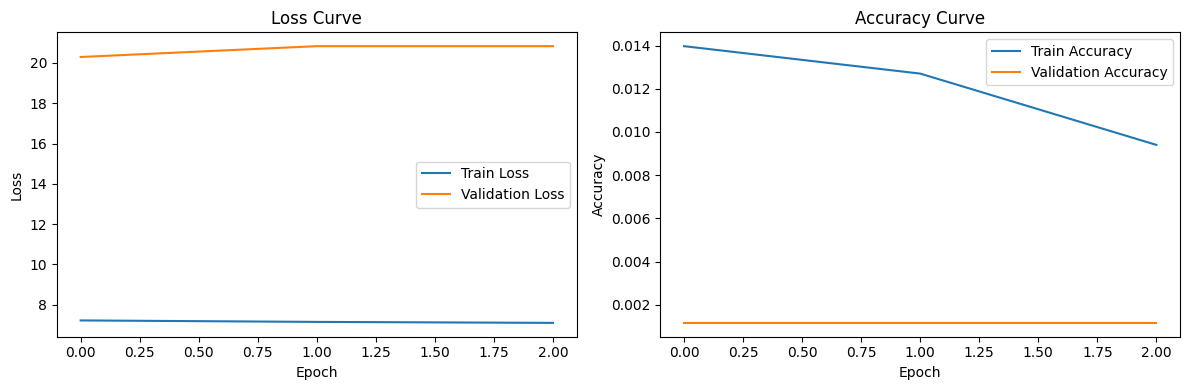

In [33]:
import viz
importlib.reload(viz)  # reloads the updated file


viz.plot_curves(train_losses, val_losses, train_accs, val_accs)

2025-11-02 14:36:07,059 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x72dbe0b30c20>
2025-11-02 14:36:07,059 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x72dbe0b30c20>


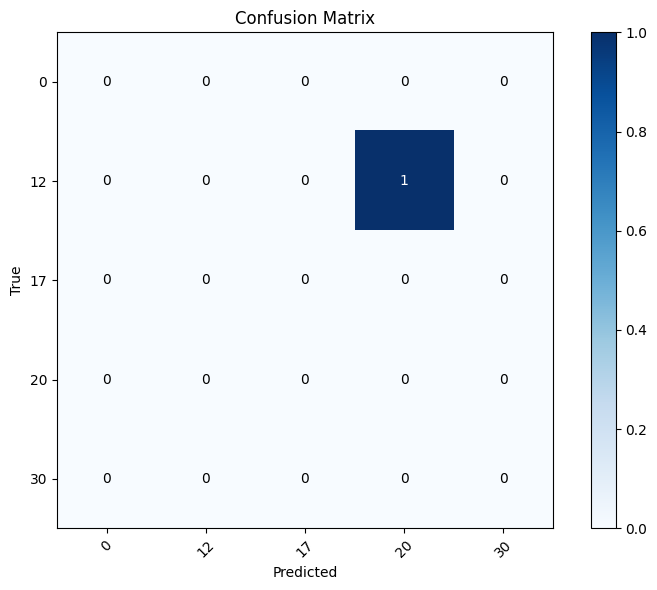

In [42]:


for batch_data, batch_labels in test_loader:
    predictions = np.argmax(model.forward(batch_data), axis=1)
    viz.plot_confusion_matrix(batch_labels, predictions, desired_classes)
    break  # Just plot the first batch for demonstration



In [ ]:
importlib.reload(viz)
# Compute and plot saliency maps one sample at a time
for batch_data, batch_labels in test_loader:
    for i, input_sample in enumerate(batch_data):
        input_sample = np.array(input_sample, dtype=float)
        saliency_map = compute_saliency_map(model, input_sample, batch_size=1000)  # Use batch_size as needed
        plot_saliency_map(saliency_map)

        if i >= 3:  # just first 4 samples for demonstration
            break
    break  # first batch only
